In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
# from lazypredict.Supervised import LazyClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *

In [ ]:
data_train = pd.read_csv("/Users/salma/Downloads/features.csv")
data_test = pd.read_csv("/Users/salma/Downloads/features_test.csv")

#concatenate train and test data
data = pd.concat([data_train, data_test])

In [ ]:
s = setup(data, target = 'Target', session_id = 123)

In [4]:
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [5]:
type(exp)

pycaret.classification.oop.ClassificationExperiment

In [6]:
exp.setup(genotype, target = 'Diagnosis', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Diagnosis
2,Target type,Multiclass
3,Target mapping,"AD: 0, CTL: 1, MCI: 2"
4,Original data shape,"(992, 13)"
5,Transformed data shape,"(992, 13)"
6,Transformed train set shape,"(694, 13)"
7,Transformed test set shape,"(298, 13)"
8,Numeric features,11
9,Categorical features,1


In [7]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.4191,0.0000,0.4191,0.4179,0.4135,0.1107,0.1114,0.0160
knn,K Neighbors Classifier,0.4021,0.0000,0.4021,0.3844,0.3766,0.0727,0.0767,0.1000
dummy,Dummy Classifier,0.3905,0.0000,0.3905,0.1525,0.2193,0.0000,0.0000,0.0050
gbc,Gradient Boosting Classifier,0.3903,0.0000,0.3903,0.3818,0.3814,0.0708,0.0713,0.0440
lightgbm,Light Gradient Boosting Machine,0.3890,0.0000,0.3890,0.3854,0.3850,0.0745,0.0748,1.1580
lr,Logistic Regression,0.3877,0.0000,0.3877,0.3253,0.2997,0.0189,0.0269,0.1470
ridge,Ridge Classifier,0.3863,0.0000,0.3863,0.3213,0.2924,0.0153,0.0252,0.0050
nb,Naive Bayes,0.3861,0.0000,0.3861,0.3743,0.3193,0.0231,0.0283,0.0050
xgboost,Extreme Gradient Boosting,0.3848,0.0000,0.3848,0.3789,0.3786,0.0643,0.0648,0.0170
et,Extra Trees Classifier,0.3847,0.0000,0.3847,0.3808,0.3794,0.0625,0.0630,0.0130


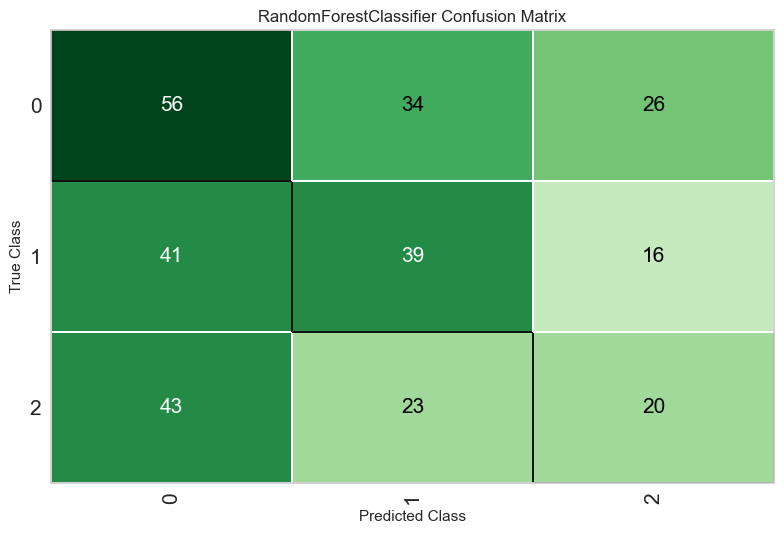

In [8]:
plot_model(best, plot = 'confusion_matrix')

In [4]:
genotype

,Subject_ID,Sex,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Diagnosis
0,DCR00003,2.00,0.01,0.03,0.02,-0.02,0.01,26.00,-0.01,-0.03,-0.00,-0.02,AD
1,DCR00004,1.00,0.01,0.03,0.02,-0.01,0.01,-0.01,-0.02,-0.00,0.02,23.00,MCI
2,DCR00005,2.00,0.01,0.02,0.01,-0.01,-0.01,-24.00,5.00,0.00,0.02,-0.01,MCI
3,DCR00006,2.00,0.01,0.03,0.01,-0.01,-0.01,-0.00,0.01,0.01,-0.00,-0.01,MCI
4,DCR00009,2.00,0.01,0.03,0.01,-0.02,-0.01,-0.01,-0.01,-0.03,16.00,-0.02,CTL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,TLSMCI605,2.00,0.02,0.01,-0.02,-0.02,0.01,-0.00,-0.01,-0.01,-0.00,0.03,MCI
988,TLSMCI609,2.00,0.02,0.01,-14.00,-0.00,0.05,-0.03,-0.02,-0.02,-0.00,16.00,MCI
989,TLSMCI610,1.00,0.02,0.02,-0.01,-0.02,0.04,-0.01,0.00,0.02,-0.00,-0.02,MCI
990,TLSMCI611,2.00,0.02,0.02,-9.00,0.00,0.07,0.01,-0.01,-0.00,-0.00,-0.00,MCI


In [10]:
y = genotype['Diagnosis']
X = genotype.drop(['Diagnosis', 'Subject_ID'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Split the data into training and testing sets based on Subject ID and equalize the classes
# Split data based on 'Subject_ID' to keep all records of a subject together
subject_ids = genotype['Subject_ID'].unique()
train_ids, test_ids = train_test_split(subject_ids, test_size=0.2, random_state=73)

train = genotype[genotype['Subject_ID'].isin(train_ids)]
test = genotype[genotype['Subject_ID'].isin(test_ids)]

# To balance the classes, you may resample the training data
# Here is an example to balance the training set by upsampling the minority classes

# Count class instances
class_counts = train['Diagnosis'].value_counts()

# Find the maximum count to match other classes
max_class_count = class_counts.max()

# Resample each class to have the same number of samples as the max class count
train_balanced = pd.DataFrame()
for class_index in class_counts.index:
    class_subset = train[train['Diagnosis'] == class_index]
    resampled_subset = resample(class_subset,
                                replace=True,  # sample with replacement
                                n_samples=max_class_count,  # to match majority class
                                random_state=42)  # reproducible results
    train_balanced = pd.concat([train_balanced, resampled_subset])

# Update X_train, y_train from the balanced dataset
X_train = train_balanced.drop(["Diagnosis", "Subject_ID"], axis=1)
y_train = train_balanced["Diagnosis"].replace({"AD": 1, "CTL": 0, "MCI": 2})

X_test = test.drop(["Diagnosis", "Subject_ID"], axis=1)
y_test = test["Diagnosis"].replace({"AD": 1, "CTL": 0, "MCI": 2})

In [31]:
#create CSV with train and test patient ids 
train_ids = train_balanced['Subject_ID']
test_ids = test['Subject_ID']

train_ids.to_csv('data/train_ids.csv', index=False)
test_ids.to_csv('data/test_ids.csv', index=False)

### Random Forrest

In [10]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.41708542713567837
F1 Score: 0.4151656240385601


In [20]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 300, 500, 700, 1000], 'max_depth': [10, 20, 30, 100]}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 30, 'n_estimators': 700}


In [23]:
#print the best score
print("Best score:", grid_search.best_score_)

Best score: 0.7813983548766158


In [24]:
#test the model
y_pred = grid_search.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.4221105527638191


In [28]:
#save the model
import joblib

joblib.dump(grid_search, "models/Genotype_random_forest_0.422.pkl")


['models/Genotype_random_forest_0.422.pkl']

In [29]:
#read the model
grid_search = joblib.load("models/Genotype_random_forest_0.422.pkl")

#test the model
y_pred = grid_search.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.4221105527638191


### Lazy Predict

In [25]:
#lazy predict
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None, random_state=42)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

 97%|█████████▋| 28/29 [00:00<00:00, 29.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2423
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 11
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


100%|██████████| 29/29 [00:02<00:00, 11.16it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.42,0.42,None,0.42,1.76
RandomForestClassifier,0.42,0.42,None,0.42,0.12
XGBClassifier,0.40,0.40,None,0.40,0.25
DecisionTreeClassifier,0.38,0.39,None,0.38,0.01
AdaBoostClassifier,0.37,0.38,None,0.37,0.06
SGDClassifier,0.39,0.36,None,0.37,0.01
BaggingClassifier,0.36,0.36,None,0.35,0.03
BernoulliNB,0.35,0.35,None,0.32,0.00
SVC,0.34,0.35,None,0.34,0.03


### DeepTables

In [ ]:
from deeptables.models import deeptable, deepnets
from deeptables.models.deeptable import DeepTable, ModelConfig
from deeptables.datasets import dsutils
from deeptables.models.deepnets import WideDeep, xDeepFM, AFM, PNN, FiBiNet, FGCNN, AutoInt, DCN


#training
conf = ModelConfig(nets=AutoInt, metrics=['accuracy', 'AUC'], auto_discrete=True, earlystopping_patience=20)
dt = deeptable.DeepTable(config=conf)

# model, history = dt.fit(X_train, y_train, epochs=500, use_multiprocessing=True)
oof_proba_fixed, eval_proba_mean_fixed, test_proba_mean_fixed = dt.fit_cross_validation(X_train, y_train, X_test=X_test, num_folds=3, epochs = 200, use_multiprocessing=True)

#evaluation
result = dt.evaluate(X_test,y_test, batch_size=10, verbose=0)
print(result)

#scoring
preds = dt.predict(X_test)
    

In [63]:
import sklearn
accuracy = sklearn.metrics.accuracy_score(y_test, preds)
f1_score = sklearn.metrics.f1_score(y_test, preds, average='macro')
precion = sklearn.metrics.precision_score(y_test, preds, average='macro')
recall = sklearn.metrics.recall_score(y_test, preds, average='macro')

print(f'Accuracy: {accuracy*100:.2f}%')
print(f'F1 Score: {f1_score*100:.2f}%')
print(f'Precision: {precion*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')


Accuracy: 43.22%
F1 Score: 25.38%
Precision: 25.84%
Recall: 34.58%


In [1]:
2/(1/0.3584 + 1/0.4458)

0.39735070877891066